This notebook is part of a series intended to review the contents in the __IBM Certified Associate Developer - Quantum Computation using Qiskit v0.2X__ exam as indicated in the [exam's official webpage](https://www.ibm.com/training/certification/C0010300) (See §Exam objectives). It is not intended, however, to furnish a complete preparation, but a guided overview with basic explanations and examples. The reader is encouraged to consult other sources and work on codes and examples as much as possible in order to prepare suitably.

# Section 3: Implementing BasicAer: Python-based simulators

Following the discussion of the last section, in this section we will know how to access and use the backends of the `BasicAer` providers to simulate quantum circuits as if they were run in an ideal (noise-free) quantum computer.

However, given a circuit we want to run, we may state the general algorithmic process of acessing and using a backend like this:

__Step 1.__ Identify a provider.

__Step 2.__ Identify the desired backend of the provider.

__Step 3.__ Transpile the circuit to the specific backend (to know what "transpilation" means see the note at the end of §1.5).

__Step 4.__ Use the backend to run the circuit.

__Step 5.__ Access the desired results of the simulation (measurement outcomes, state vectors, etc.)

We shall refer to these steps in the examples given below.

## 3.1 The BasicAer `qasm_simulator`

The main purpose of the `qasm_simulator` is to run a quantum circuit and hold its measurement outcomes. As an example, suppose that we want to run the following quantum circuit.

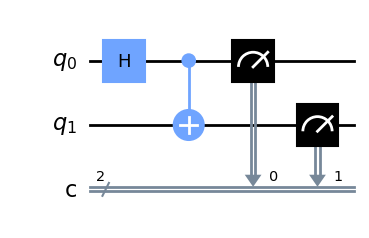

In [23]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(2, 2)

qc.h(0)
qc.cx(0, 1)
qc.measure([0, 1], [0, 1])

qc.draw('mpl')

Following the steps denoted above, we have

In [17]:
from qiskit import transpile, BasicAer # Step 1

backend = BasicAer.get_backend('qasm_simulator') # Step 2
tqc = transpile(qc, backend) # Step 3
job = backend.run(tqc, shots = 2000) # Step 4 (Shots = #times we wish to run the circuit in the simulation)

# Step 5
result = job.result()
counts = result.get_counts(tqc)

print(counts)

{'00': 979, '11': 1021}


The argument `shots` passed to the `backend.run` method in step 4 is the number of times that we want to simulate the circuit. The results printed in `counts` indicate then that we obtained approximately half of the times the outcome "00" and half of the times the outcome "11". (Like in real experiments, the higher the number of shots, the more accurate will be our results.)

Hence, we can conclude that the circuit produces the well known Bell state $(|00\rangle + |11\rangle)/\sqrt{2}$. After measuring, the state of the circuit, of course, collapses into only one of these states. This will be confirmed in the next section.

## 3.2 The  BasicAer `statevector_simulator`

The main purpose of this simulator is to run a circuit and hold its state vector. 

Suppose that we want to run the same circuit as the above section. Then, following steps similar to the ones denoted in the above section, we may proceed as follows.

In [29]:
from qiskit import transpile, BasicAer # Step 1

backend = BasicAer.get_backend('statevector_simulator') # Step 2
tqc = transpile(qc, backend) # Step 3
job = backend.run(tqc) # Step 4 (Shots = #times we wish to run the circuit in the simulation)

# Step 5
result = job.result()
psi = result.get_statevector(tqc, 4) # "4" refers to the accuracy of the entries in the state vector

print(psi)

[1.+0.j 0.+0.j 0.+0.j 0.+0.j]


Running this cell a couple times, we can confirm by the results displayed that half of the times the state of the circuit is $|00\rangle$ and the other half $|11\rangle$, as expected.

__NOTE.__ Although it is not important for this specific example, we mention that there is a subtlety in Qiskit. If a circuit has $N$ qubits $q_0$, $q_1$, $q_2$, ..., $q_N$, Qiskit organizes by default its state in the *reverse* order $|q_N, ..., q_2, q_1, q_0\rangle$.

## 3.3 The BasicAer `unitary_simulator`

The `unitary_simulator` allows to hold a unitary matrix $U$ that, when applied to the state $|00...0\rangle$ produces the final state of a given circuit. Thus, $U$ can be implemented as a gate to other circuits (or subcircuits) in order to produce the same state as the original circuit.

However, circuits that contain measurements are not allowed in thus backend. This is so because measurements are non-unitary operations. (For a more rigorous argument see the end of this section.)

To illustrate how to use this backend, let us first define the same circuit as in §3.1, but this time without measurements.

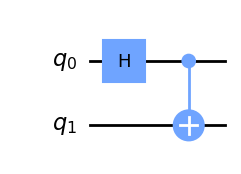

In [39]:
qc = QuantumCircuit(2)

qc.h(0)
qc.cx(0, 1)

qc.draw('mpl')

In [41]:
from qiskit import transpile, BasicAer # Step 1

backend = BasicAer.get_backend('unitary_simulator') # Step 2
tqc = transpile(qc, backend) # Step 3
job = backend.run(tqc) # Step 4 (Shots = #times we wish to run the circuit in the simulation)

# Step 5
result = job.result()
U = result.get_unitary(tqc, 4) # "4" refers to the accuracy of the entries in U

print(U)

[[ 0.7071+0.j  0.7071-0.j  0.    +0.j  0.    +0.j]
 [ 0.    +0.j  0.    +0.j  0.7071+0.j -0.7071+0.j]
 [ 0.    +0.j  0.    +0.j  0.7071+0.j  0.7071-0.j]
 [ 0.7071+0.j -0.7071+0.j  0.    +0.j  0.    +0.j]]


__Proof that quantum measurements are not unitary operations.__ Let us be more rigorous in the statement that projective measurements are not unitary operators. 

By definition, an operator $U$ is unitary iff it satisfies $U^\dagger U = 1$, that is, if its inverse is equal its conjugate transpose. This definition implies that $U$ is invertible, and, thus, has nonvanishing determinant. $U$ also takes normalized states into normalized states, as required for the correct characterization of physical systems.

Suppose then that a quantum system is in the state $|\psi\rangle = \sum_n a_n |n\rangle$, where $\{|n\rangle\}$ is an orthonormal basis. We know that a measurement returning the value $m$ induces a transition $|\psi\rangle \to |m\rangle$. If we try to describe this transition by a operator $P_m$ acting on the system the only option is then $P_m |\psi\rangle \equiv |m\rangle$. In this case we can see that $\langle\psi|P_m^\dagger P_m |\psi\rangle = \langle m|m\rangle = 1$, as required for a unitary operator. However, $P_m$ has no inverse, since all the entries of the matrix representing $P_m$ in the basis $\{|n\rangle\}$ vanish except the entry $(P_m)_{m,m} = 1$ (recall that if some row or column of a matrix vanish, it has zero determinant). Therefore, we cannot conclude that $P^\dagger P = 1$ $\square$

# References

[1] *Weaver, J. (2022). Qiskit Pocket Guide: Quantum Development with Qiskit. O'Reilly Media; 1st edition.*

[2] [Qiskit documentation](https://qiskit.org/documentation/apidoc/providers_basicaer.html)